In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from options.base_options_simple import BaseOptionsSimple
from models import create_model

%load_ext autoreload
%autoreload 2

# Sim2Seg Segmentation Model Visualization
## Load Model
Fill in `ckpt_path` with the downloaded model.

In [2]:
ckpt_path = "PATH_TO/latest_net_G.pth"
hps = "--output_nc 6 --D_type convolve --name 0712_all_evendeeper --model pix2segdepth --direction AtoB --ngf 128,256,256,512,512,1024,1024"

In [3]:
opt = BaseOptionsSimple().parse(hps.split(" ")) 
opt.num_threads = 0   # test code only supports num_threads = 0
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
model = create_model(opt)      # create a model given opt.model and other options
model.custom_load(ckpt_path)               # regular setup: load and print networks; create schedulers

----------------- Options ---------------
          D_conv_channels: 10                            
                   D_temp: 10.0                          
                   D_type: convolve                      	[default: gumbel]
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: segmentation                  
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: No

### Running Sim2Seg
Sim2Seg takes in images from `[0, 1]`, with dimensions `256x256`. To run inference:

In [4]:
def run_sim2seg(img_path, seg_path=None):
    img = np.asarray(Image.open(img_path))
    noise = torch.zeros((1, 3, 256, 256))
    img_tensor = torch.from_numpy(img).unsqueeze(0).permute(0,3,1,2) / 255
    data = {"A": img_tensor, "B": noise, "D": noise, "A_paths": noise, "B_paths": noise}
    
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()
    
    sim2seg_pred = (visuals['fake_B'][0].permute(1,2,0).cpu().numpy() + 1)/2
    
    out = np.concatenate((img / 255, sim2seg_pred), axis=1)
    
    if seg_path:
        seg_img = np.asarray(Image.open(seg_path))
        out = np.concatenate((out, seg_img / 255), axis=1)
    
    return out

## Evaluation on Sim Images
This is from our simulation dataset's test split. 

In [5]:
sim_img = "sample_images/sim_img.png"
sim_seg = "sample_images/sim_seg.png"

In [6]:
img = run_sim2seg(sim_img, sim_seg)

/tmp/ipykernel_1388808/3097985871.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272128894/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  img_tensor = torch.from_numpy(img).unsqueeze(0).permute(0,3,1,2) / 255
/home/amberxie/anaconda3/envs/motionp/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Text(0.5, 1.0, 'Input Image, Sim2Seg Prediction, True Seg')

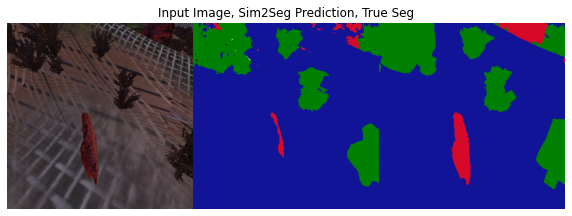

In [7]:
plt.figure(figsize=(10, 30))
plt.imshow(img)

plt.axis('off')
plt.title("Input Image, Sim2Seg Prediction, True Seg")

## Evaluation on Real-World Images
Note that we don't have ground-truth segmentations here, but hopefully this gives you a good idea of qualitative evaluations.

Text(0.5, 1.0, 'Real-World Segmentation')

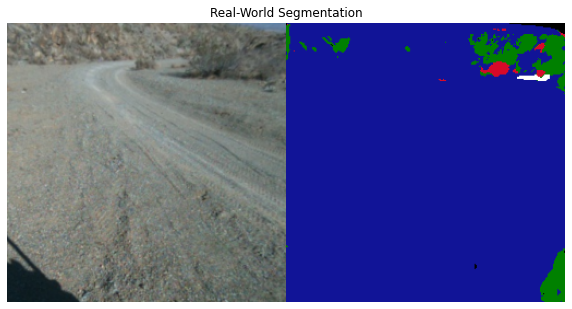

In [8]:
img = run_sim2seg("sample_images/real_img72.png")
plt.figure(figsize=(10, 30))
plt.imshow(img)

plt.axis('off')
plt.title("Real-World Segmentation")

Text(0.5, 1.0, 'Real-World Segmentation')

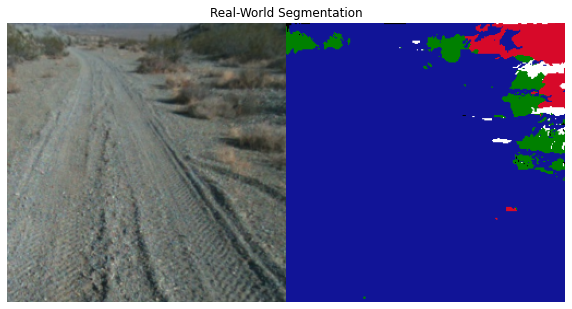

In [9]:
img = run_sim2seg("sample_images/real_img779.png")
plt.figure(figsize=(10, 30))
plt.imshow(img)

plt.axis('off')
plt.title("Real-World Segmentation")